# Project 7

## Data Cleaning

Largely inspired by this workbook: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction#Introduction:-Home-Credit-Default-Risk-Competition

<b>Dataset Description</b>: application_train/application_test: The main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.

<b>Project Objective</b>
1. Design a model that will give a probability of a client defaulting on a loan
2. Create a dashboard aimed at client managers that will allow easy interpretation of the model and to allow client managers to better understand their clients

In [27]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn.metrics import fbeta_score

# SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import Counter

import sys
sys.path.insert(0,"../data")
sys.path.insert(0,"../models")
import mlflow
import pickle

#Lime
#import lime
#import lime.lime_tabular

#LGBM
import lightgbm as lgb

from xgboost import XGBClassifier

In [28]:
# Set up environment
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
plt.rcParams['figure.figsize'] = [14, 6]

In [29]:
# Training data
app_train = pd.read_csv('../data/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [30]:
# Testing data features
app_test = pd.read_csv('../data/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

In [31]:
df_app_train = app_train.head(200)

In [32]:
df_app_train

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0        100002       1         Cash loans           M            N   
1        100003       0         Cash loans           F            N   
2        100004       0    Revolving loans           M            Y   
3        100006       0         Cash loans           F            N   
4        100007       0         Cash loans           M            N   
5        100008       0         Cash loans           M            N   
6        100009       0         Cash loans           F            Y   
7        100010       0         Cash loans           M            Y   
8        100011       0         Cash loans           F            N   
9        100012       0    Revolving loans           M            N   
10       100014       0         Cash loans           F            N   
11       100015       0         Cash loans           F            N   
12       100016       0         Cash loans           F            N   
13       100017       0         Cash loans           M            Y   
14       100018       0         Cash loans           F            N   
15       100019       0         Cash loans           M            Y   
16       100020       0         Cash loans           M            N   
17       100021       0    Revolving loans           F            N   
18       100022       0    Revolving loans           F            N   
19       100023       0         Cash loans           F            N   
20       100024       0    Revolving loans           M            Y   
21       100025       0         Cash loans           F            Y   
22       100026       0         Cash loans           F            N   
23       100027       0         Cash loans           F            N   
24       100029       0         Cash loans           M            Y   
25       100030       0         Cash loans           F            N   
26       100031       1         Cash loans           F            N   
27       100032       0         Cash loans           M            N   
28       100033       0         Cash loans           M            Y   
29       100034       0    Revolving loans           M            N   
30       100035       0         Cash loans           F            N   
31       100036       0         Cash loans           F            N   
32       100037       0         Cash loans           F            N   
33       100039       0         Cash loans           M            Y   
34       100040       0         Cash loans           F            N   
35       100041       0         Cash loans           F            N   
36       100043       0         Cash loans           F            N   
37       100044       0         Cash loans           M            N   
38       100045       0         Cash loans           F            N   
39       100046       0    Revolving loans           M            Y   
40       100047       1         Cash loans           M            N   
41       100048       0         Cash loans           F            N   
42       100049       1         Cash loans           F            N   
43       100050       0         Cash loans           F            N   
44       100051       0         Cash loans           M            N   
45       100052       0    Revolving loans           F            N   
46       100053       0         Cash loans           F            N   
47       100054       0         Cash loans           F            N   
48       100055       0         Cash loans           F            N   
49       100056       0         Cash loans           M            Y   
50       100058       0    Revolving loans           F            N   
51       100059       0         Cash loans           M            Y   
52       100060       0         Cash loans           M            Y   
53       100061       0         Cash loans           F            N   
54       100062       0         Cash loans           M            Y   
55       100063       0      

In [34]:
import evidently
from evidently.test_suite import TestSuite
from evidently.test_preset import DataStabilityTestPreset
from evidently.test_preset import DataQualityTestPreset
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

data_drift_report.run(current_data=df_app_train.iloc[:90], reference_data=df_app_train.iloc[90:], column_mapping=None)
data_drift_report


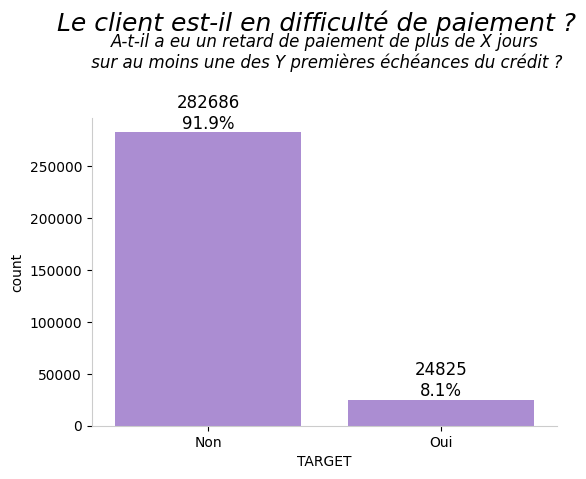

In [9]:
from xplotter.insights import *

colors = ['#AA82DD']

loan_map = {1 : "Oui",
            0 : "Non"}

fig, ax = plt.subplots(figsize=(6, 4))

plot_countplot(df=app_train, 
               col='TARGET', 
               label_names=loan_map,
               order=True,
               palette=colors, ax=ax, orient='v', size_labels=12)

plt.suptitle("Le client est-il en difficulté de paiement ?\n",
             y=1.15, fontsize=18, fontstyle='italic')
plt.title("A-t-il a eu un retard de paiement de plus de X jours\n sur au moins une des Y premières échéances du crédit ?\n\n",
           loc="center", fontsize=12, fontstyle='italic')
plt.show()

In [10]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

We are dealing with an imbalanced problem. This will be resolved using SMOTE later on.

### Encoding

We will use label encoding for every feature that has 2 categories and one-hot encoding for features with more than 2 categories.

In [11]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [12]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [13]:
# Create train labels
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
# When we do the align, we must make sure to set axis = 1 to align the dataframes based on the columns and not on the rows!
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


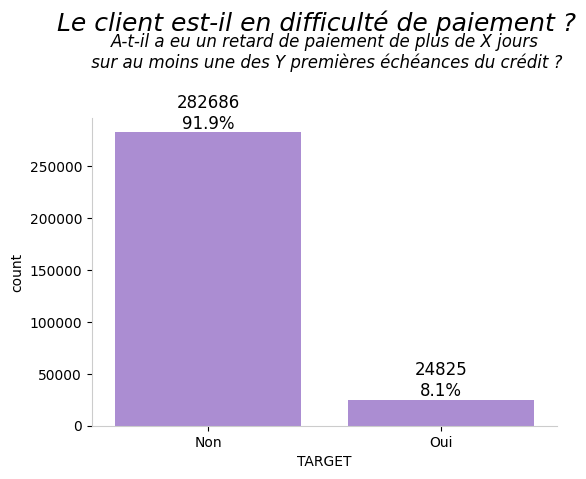

In [14]:
from xplotter.insights import *

colors = ['#AA82DD']

loan_map = {1 : "Oui",
            0 : "Non"}

fig, ax = plt.subplots(figsize=(6, 4))

plot_countplot(df=app_train, 
               col='TARGET', 
               label_names=loan_map,
               order=True,
               palette=colors, ax=ax, orient='v', size_labels=12)

plt.suptitle("Le client est-il en difficulté de paiement ?\n",
             y=1.15, fontsize=18, fontstyle='italic')
plt.title("A-t-il a eu un retard de paiement de plus de X jours\n sur au moins une des Y premières échéances du crédit ?\n\n",
           loc="center", fontsize=12, fontstyle='italic')
plt.show()

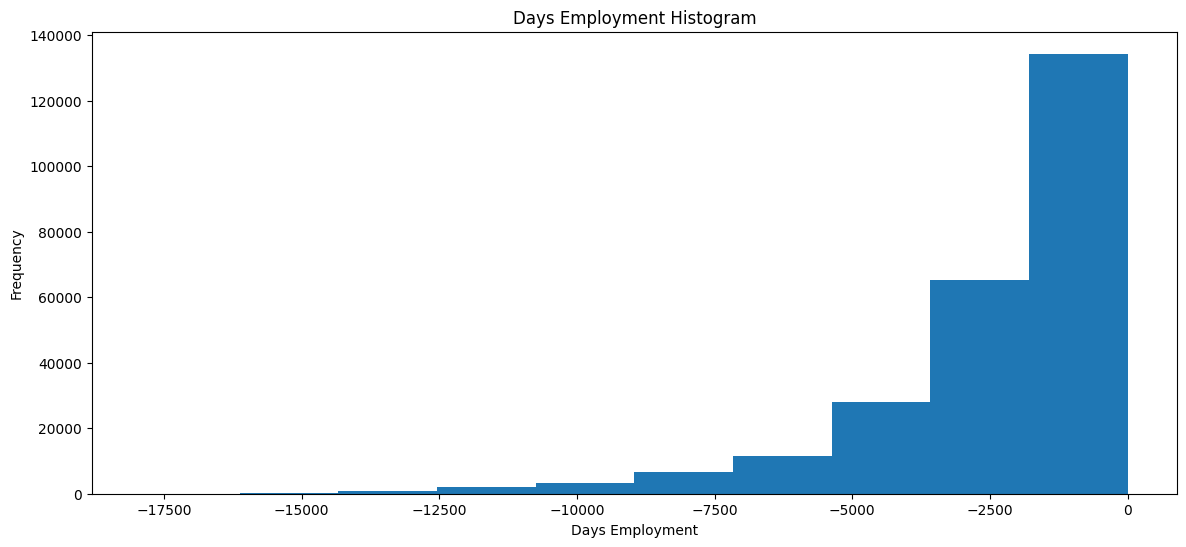

In [15]:
# Dealing with issues in the Employment column
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [16]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [17]:
# Adding domain-specific features
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [18]:
# Adding domain-specific features
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

In [19]:
print('Training Features shape: ', app_train_domain.shape)
print('Testing Features shape: ', app_test_domain.shape)

Training Features shape:  (307511, 245)
Testing Features shape:  (48744, 244)


In [20]:
app_train_domain.info(verbose = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 245 columns):
 #    Column                                             Dtype  
---   ------                                             -----  
 0    SK_ID_CURR                                         int64  
 1    NAME_CONTRACT_TYPE                                 int32  
 2    FLAG_OWN_CAR                                       int32  
 3    FLAG_OWN_REALTY                                    int32  
 4    CNT_CHILDREN                                       int64  
 5    AMT_INCOME_TOTAL                                   float64
 6    AMT_CREDIT                                         float64
 7    AMT_ANNUITY                                        float64
 8    AMT_GOODS_PRICE                                    float64
 9    REGION_POPULATION_RELATIVE                         float64
 10   DAYS_BIRTH                                         int64  
 11   DAYS_EMPLOYED                        

In [21]:
app_train_domain.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002                   0             0                1   
1      100003                   0             0                0   
2      100004                   1             1                1   
3      100006                   0             0                1   
4      100007                   0             0                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461         -637.0            -3648.0   
1                    0.003541      -16765        -1188.0            -1186.0   
2                    0.010032      -19046         -225.0            -4260.0   
3                    0.008019      -19005        -3039.0            -9833.0   
4                    0.028663      -19932        -3038.0            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   
2                 1           1           0              1.0   
3                 1           0           0              2.0   
4                 1           0           0              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083037   
1                       0                        0      0.311267   
2                       0                        0           NaN   
3                       0                        0           NaN   
4                       1                        1           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.262949      0.139376          0.0247            0.0369   
1      0.622246           NaN   

### Data Integrity Checks

In [22]:
# Count of children
app_train_domain['CNT_CHILDREN'].value_counts()

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
12         2
10         2
19         2
11         1
Name: CNT_CHILDREN, dtype: int64

In [23]:
# Drop all records with more than 7 children
app_train_domain = app_train_domain[app_train_domain['CNT_CHILDREN'] <=7]

In [24]:
#app_train_domain.to_csv('../data/unscaled_data.csv')

In [25]:
# Creating small unscaled dataset for use in dashboard
unscaled_data_columns = ['SK_ID_CURR', 'TARGET', 'AMT_CREDIT']
unscaled_data = app_train_domain[unscaled_data_columns]
#unscaled_data.to_csv('../data/unscaled_data_small.csv')

In [26]:
# Creating sample for use in dashboard
app_train_domain_sample = app_train_domain.sample(int(len(app_train_domain)*0.1))

In [24]:
#app_train_domain_sample.to_csv('')

## Building Models

### Prep full data

In [25]:
# Create train labels
train_labels = app_train_domain['TARGET']
train = app_train_domain.copy()

# Drop the IDs and record them for later
train_ids = train['SK_ID_CURR']
train.drop(columns = ['SK_ID_CURR'], inplace = True)

# Feature names
features = list(train.columns)

# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)

print('Training data shape: ', train.shape)

Training data shape:  (307497, 244)


In [26]:
# Recreate a data frame from the training dataset
df_final = pd.DataFrame(train, columns = features)

In [27]:
df_final

NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0                      0.0           0.0              1.0           0.0   
1                      0.0           0.0              0.0           0.0   
2                      1.0           1.0              1.0           0.0   
3                      0.0           0.0              1.0           0.0   
4                      0.0           0.0              1.0           0.0   
...                    ...           ...              ...           ...   
307492                 0.0           0.0              0.0           0.0   
307493                 0.0           0.0              1.0           0.0   
307494                 0.0           0.0              1.0           0.0   
307495                 0.0           0.0              1.0           0.0   
307496                 0.0           0.0              0.0           0.0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0               0.001512    0.090287     0.090032         0.077441   
1               0.002089    0.311736     0.132924         0.271605   
2               0.000358    0.022472     0.020025         0.023569   
3               0.000935    0.066837     0.109477         0.063973   
4               0.000819    0.116854     0.078975         0.117845   
...                  ...         ...          ...              ...   
307492          0.001127    0.052360     0.101176         0.046016   
307493          0.000396    0.056067     0.040505         0.046016   
307494          0.001089    0.157969     0.110618         0.135802   
307495          0.001243    0.081175     0.072499         0.069585   
307496          0.001127    0.157303     0.185258         0.158249   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                         0.256321    0.888839       0.964437   
1                         0.045016    0.477114       0.933676   
2                         0.134897    0.348534       0.987439   
3                         0.107023    0.350846       0.830337   
4                         0.392880    0.298591       0.830393   
...                            ...         ...            ...   
307492                    0.446855    0.896392       0.986824   
307493                    0.344429    0.251071       0.907995   
307494                    0.065247    0.578523       0.557782   
307495                    0.069553    0.747914       0.732805   
307496                    0.635991    0.471984       0.929544   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0                0.852140         0.705433     0.098901         1.0   
1                0.951929         0.959566     0.098901         1.0   
2                0.827335         0.648326     0.285714         1.0   
3                0.601451         0.661387     0.098901         1.0   
4                0.825268         0.519522     0.098901         1.0   
...                   ...              ...          ...         ...   
307492           0.657263         0.724607     0.098901         1.0   
307493           0.822147         0.431708     0.098901         1.0   
307494           0.726937         0.284424     0.098901         1.0   
307495           0.896158         0.870641     0.098901         1.0   
307496           0.792153         0.943032     0.098901         1.0   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0                  1.0              0.0               1.0         1.0   
1                  1.0              0.0               1.0         1.0   
2                  1.0              1.0               1.0         1.0   
3                  1.0              0.0               1.0         0.0   
4                  1.0              0.0               1.0         0.0   
...                ...              ...               ...         ...   
307492             1.0              0.0               1.0         0.0   
307493             0.0              0.0         

In [28]:
df_final['SK_ID_CURR'] = train_ids

In [29]:
train_ids

0         100002
1         100003
2         100004
3         100006
4         100007
           ...  
307506    456251
307507    456252
307508    456253
307509    456254
307510    456255
Name: SK_ID_CURR, Length: 307497, dtype: int64

In [30]:
# Create data sample for use in dashboard
df_final_sample = df_final.sample(n = int(len(df_final)*0.1))

In [31]:
# Drop target column and convert to array for training
train = df_final.drop(columns = ['TARGET', 'SK_ID_CURR'])


In [32]:
Counter(train_labels)

Counter({1: 24822, 0: 282675})

In [33]:
# Define a dataframe to store the results of our different models
results = pd.DataFrame(columns=['model', 'score', 'train_score', 'test_score', 'accuracy', 'auc', 'beta'])

# Create F-Beta scorer
f_beta = make_scorer(fbeta_score, beta=2)

# Define the two scoring techniques for our models
scoring = {'F-Beta': f_beta,
           'ROC AUC': 'roc_auc'}

In [34]:
results

Empty DataFrame
Columns: [model, score, train_score, test_score, accuracy, auc, beta]
Index: []

## Dealing with Imbalanced Learning

### SMOTE

As we saw earlier, we are clearly dealing with an imbalanced learning problem here, we will try to address this using SMOTE. According to the article and the original paper, the best strategy is to use a combination of over and under-sampling by over-sampling to reach a certain threshold and then under-sampling to match that threshold to a 1:2 level. This will also reduce the number of observations in our dataset.

Inspiration: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [35]:
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, test_size=0.4, random_state=52)

### Logistic Regression

#### NO SMOTE

In [38]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, accuracy_score, roc_auc_score

# Define model
model = LogisticRegression(random_state=52)

# Fit model and calculate scores for beta = 2
log_reg = model.fit(X_train, y_train)
y_pred_test = log_reg.predict(X_test)
y_pred_train = log_reg.predict(X_train)
train_score = fbeta_score(y_train, y_pred_train, beta=2)
test_score = fbeta_score(y_test, y_pred_test, beta=2)
accuracy = accuracy_score(y_test, y_pred_test)
auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])


# Create results dataframe
results = results.append({'model': 'Logistic Regression - No Smote',
                        'score':'F-Beta',
                        'train_score': train_score,
                        'test_score': test_score,
                        'accuracy': accuracy,
                        'auc': auc,
                        'beta': 2
                       }, ignore_index = True)



In [39]:
import mlflow
import mlflow.sklearn

# Démarrez une nouvelle exécution MLflow
with mlflow.start_run():
    
    # Load the model
    log_reg_tuned = pickle.load(open('./models/LRCSmote.obj', 'rb'))

    # Calculate F-beta, Accuracy, and AUC scores
    log_reg_tuned = log_reg_tuned.fit(X_train, y_train)
    y_pred_test = log_reg_tuned.predict(X_test)
    y_pred_train = log_reg_tuned.predict(X_train)
    train_score = fbeta_score(y_train, y_pred_train, beta=2)
    test_score = fbeta_score(y_test, y_pred_test, beta=2)
    accuracy = accuracy_score(y_test, y_pred_test)
    auc = roc_auc_score(y_test, log_reg_tuned.predict_proba(X_test)[:, 1])

    # Enregistrez le modèle dans MLflow
    mlflow.sklearn.log_model(log_reg_tuned, "log_reg_tuned")

    # Enregistrez les métriques dans MLflow
    mlflow.log_metric('train_score', train_score)
    mlflow.log_metric('test_score', test_score)
    mlflow.log_metric('accuracy', accuracy)
    mlflow.log_metric('auc', auc)

    # Ajoutez les métriques dans le dataframe des résultats
    results = results.append({
        'model': 'Logistic Regression With Smote',
        'score': 'F-Beta',
        'train_score': train_score,
        'test_score': test_score,
        'accuracy': accuracy,
        'auc': auc,
        'beta': 2
    }, ignore_index=True)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


#### With SMOTE

In [ ]:
with open('tree.obj', 'wb') as file:
    pickle.dump(log_reg_tuned, file)

In [77]:
# Define model
model = LogisticRegression(random_state = 52)

# Define pipeline
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

# Parameter grid
parameters = {'model__penalty': ['l1', 'l2'],
              'model__C': [10,1,0.1]
             }

# Hyperparameter Tuning
log_reg_search = GridSearchCV(estimator = pipeline, 
                              param_grid = parameters,
                              cv = 4, 
                              verbose = 3,
                              n_jobs = -1, 
                              scoring = f_beta
                             )

# Fit model
log_reg_tuned = log_reg_search.fit(X_train, y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


In [78]:
pickle.dump(log_reg_tuned, open('./models/LRCSmote.pkl', 'wb'))

In [102]:
log_reg_tuned

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('over', SMOTE(sampling_strategy=0.3)),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.5)),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [10, 1, 0.1],
                         'model__penalty': ['l1', 'l2']},
             scoring=make_scorer(fbeta_score, beta=2), verbose=3)

In [2]:
mod = pickle.load(open('./models/LRCSmote.obj', 'rb'))

In [25]:
prediction = mod.predict_proba(df_test)[:, 1][0]

In [26]:
prediction

0.9440477250305503

In [116]:
pickle.dump(log_reg_tuned, open('./models/LRCSmote.obj', 'wb'))

In [142]:
import mlflow
import mlflow.sklearn
import pickle
from sklearn.metrics import accuracy_score, fbeta_score, roc_auc_score


# Start MLflow runfrom evidently.report import Report
from evidently.metric_preset import DataDriftPreset

    # Load the model
log_reg_tuned = pickle.load(open('./models/LRCSmote.obj', 'rb'))

    # Calculate F-beta, Accuracy, and AUC scores

log_reg_tuned = log_reg_search.fit(X_train, y_train)
y_pred_test = log_reg_tuned.predict(X_test)
y_pred_train = log_reg_tuned.predict(X_train)
train_score = fbeta_score(y_train, y_pred_train, beta=2)
test_score = fbeta_score(y_test, y_pred_test, beta=2)
accuracy = accuracy_score(y_test, y_pred_test)
auc = roc_auc_score(y_test, log_reg_tuned.predict_proba(X_test)[:, 1])


    
results = results.append({'model': 'Logistic Regression With Smote',
                        'score': 'F-Beta',
                        'train_score': train_score,
                        'test_score': test_score,
                        'accuracy': accuracy,
                        'auc': auc,
                        'beta': 2}, ignore_index = True)


Fitting 4 folds for each of 6 candidates, totalling 24 fits


In [143]:
results

model   score  train_score  test_score  accuracy  \
0  Logistic Regression - No Smote  F-Beta     0.015256    0.015772  0.919910   
1  Logistic Regression With Smote  F-Beta     0.359915    0.345907  0.833901   

        auc beta  
0  0.744103    2  
1  0.737743    2

In [ ]:
import evidently
from evidently.test_suite import TestSuite
from evidently.test_preset import DataStabilityTestPreset
from evidently.test_preset import DataQualityTestPreset
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

data_drift_report.run(current_data=app_train.iloc[:90], reference_data=app_train.iloc[90:], column_mapping=None)
data_drift_report.save("data_test.html")


In [283]:
data_drift_dashboard.calculate(reference, current, column_mapping=column_mapping)
data_drift_dashboard.save("data_drifte_LRS.html")

In [59]:
# Serialize model
pickle.dump(log_reg_tuned, open('./models/LRModel2.obj', 'wb'))

### XG Boost

In [144]:
# Define model
xgb = XGBClassifier(objective='binary:logistic', random_state = 42)

# Define pipeline
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', xgb)]
pipeline = Pipeline(steps=steps)

# Parameter grid
parameters = {'model__max_depth': [4,5,6],
              'model__min_child_weight': [1,3]
             }

# Hyperparameter Tuning
xgb_search = GridSearchCV(estimator = pipeline, 
                              param_grid = parameters,
                              cv = 4, 
                              verbose = 3,
                              n_jobs = -1, 
                              scoring = f_beta
                             )

#Variable 1
xgbtuned = xgb_search.fit(X_train, y_train)

Fitting 4 folds for each of 6 candidates, totalling 24 fits


KeyboardInterrupt: 

In [145]:
xgbtuned = pickle.load(open('./models/XGBModel3.obj', 'rb'))
y_pred_test = xgbtuned.predict(X_test)
y_pred_train = xgbtuned.predict(X_train)
train_score = fbeta_score(y_train, y_pred_train, beta=2)
test_score = fbeta_score(y_test, y_pred_test, beta=2)
accuracy = accuracy_score(y_test, y_pred_test)
auc = roc_auc_score(y_test, xgbtuned.predict_proba(X_test)[:, 1])


    
results = results.append({'model': 'XG Boost',
                        'score': 'F-Beta',
                        'train_score': train_score,
                        'test_score': test_score,
                        'accuracy': accuracy,
                        'auc': auc,
                        'beta': 2}, ignore_index = True)

In [146]:
results

model   score  train_score  test_score  accuracy  \
0  Logistic Regression - No Smote  F-Beta     0.015256    0.015772  0.919910   
1  Logistic Regression With Smote  F-Beta     0.359915    0.345907  0.833901   
2                        XG Boost  F-Beta     0.207189    0.111973  0.914772   

        auc beta  
0  0.744103    2  
1  0.737743    2  
2  0.748946    2

In [51]:
# Serialize model
pickle.dump(xgbtuned, open('./models/XGBModel3.obj', 'wb'))

### Light Gradient Boosting

In [52]:
# Define model
lgbm = lgb.LGBMClassifier(objective = 'binary', random_state = 42)

# Define pipeline
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', lgbm)]
pipeline = Pipeline(steps=steps)

# Parameter grid
parameters = {'model__is_unbalance': [True, False],
              'model__boosting_type': ['gbdt', 'goss']
             }

# Hyperparameter Tuning
lgbm_search = GridSearchCV(estimator = pipeline, 
                              param_grid = parameters,
                              cv = 4, 
                              verbose = 3,
                              n_jobs = -1, 
                              scoring = f_beta
                             )

# Fit model
lgbm_tuned = lgbm_search.fit(X_train, y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


In [147]:
lgbm_tuned = pickle.load(open('./models/LGBModel2.obj', 'rb'))
y_pred_test = lgbm_tuned.predict(X_test)
y_pred_train = lgbm_tuned.predict(X_train)
train_score = fbeta_score(y_train, y_pred_train, beta=2)
test_score = fbeta_score(y_test, y_pred_test, beta=2)
accuracy = accuracy_score(y_test, y_pred_test)
auc = roc_auc_score(y_test, lgbm_tuned.predict_proba(X_test)[:, 1])


    
results = results.append({'model': 'Light Gradient Boosting',
                        'score': 'F-Beta',
                        'train_score': train_score,
                        'test_score': test_score,
                        'accuracy': accuracy,
                        'auc': auc,
                        'beta': 2}, ignore_index = True)

In [148]:
results

model   score  train_score  test_score  accuracy  \
0  Logistic Regression - No Smote  F-Beta     0.015256    0.015772  0.919910   
1  Logistic Regression With Smote  F-Beta     0.359915    0.345907  0.833901   
2                        XG Boost  F-Beta     0.207189    0.111973  0.914772   
3         Light Gradient Boosting  F-Beta     0.277827    0.273126  0.890186   

        auc beta  
0  0.744103    2  
1  0.737743    2  
2  0.748946    2  
3  0.766202    2

In [48]:
# Serialize model
pickle.dump(lgbm_tuned, open('./models/LGBModel2.obj', 'wb'))

#### Random Forest

In [49]:
# Define model
rfc = RandomForestClassifier(random_state = 42)

# Define pipeline
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', rfc)]
pipeline = Pipeline(steps=steps)

# Parameter grid
parameters = {'model__min_samples_split': [2,4]
             }

# Hyperparameter Tuning
rfc_search = GridSearchCV(estimator = pipeline, 
                              param_grid = parameters,
                              cv = 4, 
                              verbose = 3,
                              #n_jobs =-1, 
                              scoring = f_beta
                             )

#Variable 1
rfc_tuned = rfc_search.fit(X_train, y_train)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV 1/4] END ........model__min_samples_split=2;, score=0.033 total time= 1.3min
[CV 2/4] END ........model__min_samples_split=2;, score=0.037 total time= 1.3min
[CV 3/4] END ........model__min_samples_split=2;, score=0.045 total time= 1.3min
[CV 4/4] END ........model__min_samples_split=2;, score=0.037 total time= 1.2min
[CV 1/4] END ........model__min_samples_split=4;, score=0.038 total time= 1.2min
[CV 2/4] END ........model__min_samples_split=4;, score=0.039 total time= 1.2min
[CV 3/4] END ........model__min_samples_split=4;, score=0.043 total time= 1.1min
[CV 4/4] END ........model__min_samples_split=4;, score=0.043 total time= 1.1min


In [149]:
rfc_tuned  = pickle.load(open('./models/RFCModel2.obj', 'rb'))
y_pred_test = rfc_tuned.predict(X_test)
y_pred_train = rfc_tuned.predict(X_train)
train_score = fbeta_score(y_train, y_pred_train, beta=2)
test_score = fbeta_score(y_test, y_pred_test, beta=2)
accuracy = accuracy_score(y_test, y_pred_test)
auc = roc_auc_score(y_test, rfc_tuned.predict_proba(X_test)[:, 1])


    
results = results.append({'model': 'Random Forest',
                        'score': 'F-Beta',
                        'train_score': train_score,
                        'test_score': test_score,
                        'accuracy': accuracy,
                        'auc': auc,
                        'beta': 2}, ignore_index = True)

In [151]:
results
#Overfiting avec Random Forest on va l'enlever

model   score  train_score  test_score  accuracy  \
0  Logistic Regression - No Smote  F-Beta     0.015256    0.015772  0.919910   
1  Logistic Regression With Smote  F-Beta     0.359915    0.345907  0.833901   
2                        XG Boost  F-Beta     0.207189    0.111973  0.914772   
3         Light Gradient Boosting  F-Beta     0.277827    0.273126  0.890186   
4                   Random Forest  F-Beta     0.738848    0.741863  0.973040   

        auc beta  
0  0.744103    2  
1  0.737743    2  
2  0.748946    2  
3  0.766202    2  
4  0.941951    2

In [ ]:
### Serialize model
pickle.dump(rfc_tuned, open('./models/RFCModel2.obj', 'wb'))